# Requirements

In [2]:
import os
import json
import pandas as pd
import numpy as np
import json
import pickle
import random
import unicodedata
import requests
import re

### plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#from scipy import stats

import spacy
from spacy.tokens import DocBin



import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

In [3]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [4]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

AGT_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1iVta_FuEDgUM_Lf_yByrdbbXNoVH_dnVZs6QRyYv1NM/edit?usp=sharing")

CEMRAM_OVERVIEW = gc.open_by_url("https://docs.google.com/spreadsheets/d/1W5lBT2vxPXJZP06dRacNgEaM9wF9UlFnxiPq28vJJTg/edit?usp=sharing")

# AGT_metadata = gc.open_by_url("https://docs.google.com/spreadsheets/d/1hEUnL3E07F-EnE3wYnk1V91aXfPDrcnhFHKjD-04CM0/edit?usp=sharing")

In [5]:
AGT = sddk.read_file("SDAM_data/AGT/AGT_lemmatized_20201119.json", "df", conf)

In [6]:
AGT.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,3252,"[[ἄρχω, Φοῖβε, παλαιγενέων, κλέα, φώς, μιμνήσκ...","[ἄρχω, Φοῖβε, παλαιγενέων, κλέα, φώς, μιμνήσκω...",24689
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,150118,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,6068,"[[Θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...","[Θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",71509
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,110763,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,10245,"[[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρ...","[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρχ...",59639
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,1982,"[[ψιθύρισμα, πίτυς, αἰπόλε, τῆνος, παγαῖσι, με...","[ψιθύρισμα, πίτυς, αἰπόλε, τῆνος, παγαῖσι, μελ...",12193
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,152,"[[ῥόδον, δροσόεντα, κατάπυκνος, ἐκείνα, ἕρπυλλ...","[ῥόδον, δροσόεντα, κατάπυκνος, ἐκείνα, ἕρπυλλο...",1108


# TLG epithet

In [7]:
resp = requests.get("https://raw.githubusercontent.com/kylepjohnson/cltk/master/cltk/corpus/greek/tlg/author_epithet.json")
tlg_author_epithet = json.loads(resp.content)

In [8]:
tlg_author_epithet_reversed = {}
for key in tlg_author_epithet.keys():
    for author_id in tlg_author_epithet[key]:
        tlg_author_epithet_reversed["tlg" + author_id] = key           

In [9]:
tlg_author_epithet_reversed

def get_epithet(author_id): # we use doc_id, since author id was modified
    try:
        epithets = tlg_author_epithet_reversed[author_id[:7]]
    except:
        epithets = []
    return epithets

AGT["tlg_epithet"] = AGT["author_id"].apply(get_epithet)

In [70]:
# read the dataset
sddk.write_file("SDAM_data/AGT/AGT_20201027.json", AGT, conf)

A file with the same name ("AGT_20201027.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_20201027.json"


# Export latest data for improvement...

In [43]:
AGT.columns

Index(['filename', 'author', 'title', 'string', 'wordcount', 'author_id',
       'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual',
       'provenience', 'lemmata', 'lemmata_wordcount', 'lemmatized_sentences',
       'n_sentences', 'tlg_epithet'],
      dtype='object')

In [44]:
AGT.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,lemmata,lemmata_wordcount,lemmatized_sentences,n_sentences,tlg_epithet
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,"[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσκ...",24237,"[[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσ...",3230,Epici/-ae
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,\nΘουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶ...,150126,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,"[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",68154,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...",6057,Historici/-ae
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,110773,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,"[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρχ...",55323,"[[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρ...",9906,Biographi
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,\n̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα...,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότη...",12177,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότ...",1725,Bucolici
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλο...",1089,"[[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλ...",135,Bucolici


In [45]:
set_with_dataframe(CEMRAM_OVERVIEW.worksheet("works_overview"), AGT.drop(["string", "lemmata", "lemmatized_sentences"], axis=1))

# A preliminary overview

In [10]:
len(AGT)

1457

In [11]:
### total number of words
AGT["wordcount"].sum() # 33419267

31248866

In [12]:
len(AGT[AGT["date_avr"].notnull()])

1359

In [13]:
# number of documents before the end of the 4th c. CE

len(AGT[AGT["date_avr"].notnull()][AGT["date_avr"] < 4])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


1255

# Comparing different approaches to dating

In [14]:
AGT.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,tlg_epithet
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,3252,"[[ἄρχω, Φοῖβε, παλαιγενέων, κλέα, φώς, μιμνήσκ...","[ἄρχω, Φοῖβε, παλαιγενέων, κλέα, φώς, μιμνήσκω...",24689,Epici/-ae
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,150118,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,6068,"[[Θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...","[Θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",71509,Historici/-ae
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,110763,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,10245,"[[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρ...","[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρχ...",59639,Biographi
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,1982,"[[ψιθύρισμα, πίτυς, αἰπόλε, τῆνος, παγαῖσι, με...","[ψιθύρισμα, πίτυς, αἰπόλε, τῆνος, παγαῖσι, μελ...",12193,Bucolici
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,152,"[[ῥόδον, δροσόεντα, κατάπυκνος, ἐκείνα, ἕρπυλλ...","[ῥόδον, δροσόεντα, κατάπυκνος, ἐκείνα, ἕρπυλλο...",1108,Bucolici


In [15]:
centuries = [num + 0.5 for num in range(-8, 4)]
centuries

[-7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

In [16]:
dates = [num /10 for num in range(-75, 40, 5)]
print(dates)

[-7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [17]:
AGT["date_probs"].tolist()[0]["-2.5"]

1

In [18]:
centuries_aor = {}
def get_prob(x):
    try: return x[str(century)]
    except: return 0
for century in centuries:
    centuries_aor[century] =  AGT["date_probs"].apply(get_prob).sum()
centuries_aor

{-7.5: 6.8331,
 -6.5: 3.8331,
 -5.5: 9.8331,
 -4.5: 139.0,
 -3.5: 234.0001,
 -2.5: 42.2501,
 -1.5: 12.9586,
 -0.5: 40.8964,
 0.5: 168.3657,
 1.5: 450.1011,
 2.5: 77.97030000000001,
 3.5: 68.9081}

In [19]:
centuries_aor_df = pd.DataFrame(centuries_aor, index=[0]).T[:6]
centuries_aor_df

,0
-7.5,6.8331
-6.5,3.8331
-5.5,9.8331
-4.5,139.0000
-3.5,234.0001
-2.5,42.2501
-1.5,12.9586
-0.5,40.8964
0.5,168.3657
1.5,450.1011


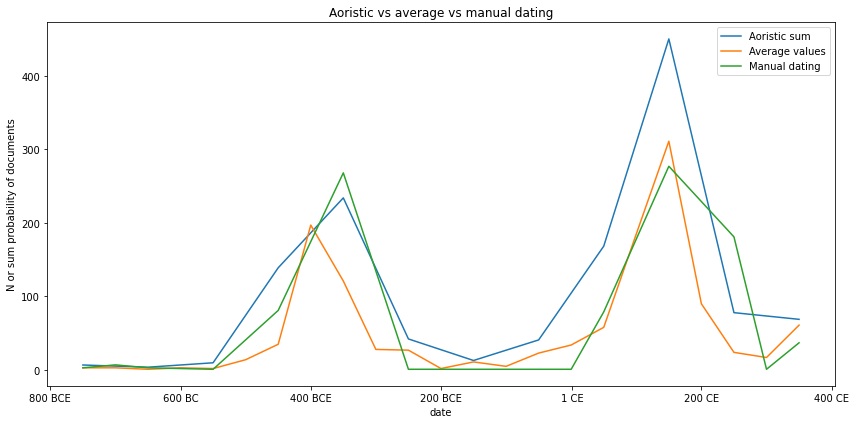

In [20]:
### documents with probabilities
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

centuries_aor_df.plot(ax=ax)
AGT.groupby("date_avr").size()[:3.5].plot(ax=ax)
AGT.groupby("date_manual").size()[:3.5].plot(ax=ax)
ax.set_xlabel("date")
ax.set_ylabel("N or sum probability of documents")
ax.set_xticks([-8, -6, -4, -2, 0.01, 2, 4])
ax.set_xticklabels(["800 BCE", "600 BC", "400 BCE", "200 BCE", "1 CE", "200 CE", "400 CE"])

plt.title("Aoristic vs average vs manual dating")
plt.legend(labels=["Aoristic sum", "Average values", "Manual dating"])

In [21]:
sddk.write_file("SDAM_data/AGT/AGT_dating_overview_20201119.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_dating_overview_20201119.png"


# Overview of authors

In [22]:
authors = []
for author_id in AGT["author_id"].unique().tolist():
  author_df = AGT[AGT["author_id"]==author_id]
  try: author = "/".join(author_df["author"].unique().tolist())
  except: author = author_df["author"].unique().tolist()[0]
  wordcount = author_df["wordcount"].sum()
  provenience = author_df["provenience"].unique().tolist()[0]
  date = author_df["date_avr"].unique().tolist()[0]
  author_data = [author_id, author, provenience, date, len(author_df), wordcount]
  authors.append(author_data)

In [23]:
authors_df = pd.DataFrame(authors)
authors_df.columns = ["author id", "name", "provenience", "date", "N of works", "N of words"]
authors_df.head(5)

,author id,name,provenience,date,N of works,N of words
0,tlg0001,Apollonius Rhodius,pagan,-2.5,1,38822
1,tlg0003,Thucydides,pagan,-4.5,1,150118
2,tlg0004,Diogenes Laertius,,2.5,1,110763
3,tlg0005,Theocritus,,-3.0,3,21011
4,tlg0006,Euripides,pagan,-4.5,17,134129


In [60]:
len(authors_df)

274

In [172]:
# set_with_dataframe(AGT_overview.add_worksheet("authors_overview_20201027", rows=1, cols=1), authors_df)

# Wordcounts overview

In [24]:
dates

[-7.5,
 -7.0,
 -6.5,
 -6.0,
 -5.5,
 -5.0,
 -4.5,
 -4.0,
 -3.5,
 -3.0,
 -2.5,
 -2.0,
 -1.5,
 -1.0,
 -0.5,
 0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5]

In [25]:
def date_avr_to_string(date):
    if str(date)[-1]=="5":
        date_number = str(int(abs(date) + 0.5))
       
    else: 
        if date < 0:
            date_number = str(int(abs(date) + 1))  + "/" + str(int(abs(date)))
        else: 
            date_number = str(int(abs(date)))  + "/" + str(int(abs(date) + 1))
    if date < 0: date_string = date_number + " BCE"
    else: date_string = date_number + " CE"
    if date == 0.0:
        date_string = "1 BCE/1 CE"
    return date_string

In [26]:
subselections = []
for date in dates:
    subselection = AGT[AGT["date_avr"]== date]
    wordcount_christian = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]=="christian")]["wordcount"].sum()
    wordcount_pagan = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]!="christian")]["wordcount"].sum()
    wordcount = subselection["wordcount"].sum()
    sentences = subselection["lemmatized_sentences"].apply(lambda x: len(x)).sum()
    doccount = len(subselection)
    date_string = date_avr_to_string(date)
    subselection_dict = {"date_string" : date_string, "column" : "date_avr", "value" : date, "wordcount" : wordcount, "sentences" : sentences, "wordcount_christian" : wordcount_christian, "wordcount_pagan" : wordcount_pagan, "doccount": doccount}
    subselections.append(subselection_dict)
subselections_df = pd.DataFrame(subselections)
subselections_df

,date_string,column,value,wordcount,sentences,wordcount_christian,wordcount_pagan,doccount
0,8 BCE,date_avr,-7.5,199822,15216,0,199822,3
1,8/7 BCE,date_avr,-7.0,16193,1183,0,16193,3
2,7 BCE,date_avr,-6.5,144,13,0,144,1
3,7/6 BCE,date_avr,-6.0,9268,699,0,9268,3
4,6 BCE,date_avr,-5.5,39711,3391,0,39711,2
5,6/5 BCE,date_avr,-5.0,66272,6059,0,66272,14
6,5 BCE,date_avr,-4.5,558265,39854,0,558265,35
7,5/4 BCE,date_avr,-4.0,1557973,122693,0,1557973,197
8,4 BCE,date_avr,-3.5,1278461,87478,0,1278461,121
9,4/3 BCE,date_avr,-3.0,207682,24391,0,207682,28


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0.5, 1.0, 'Corpus overview')

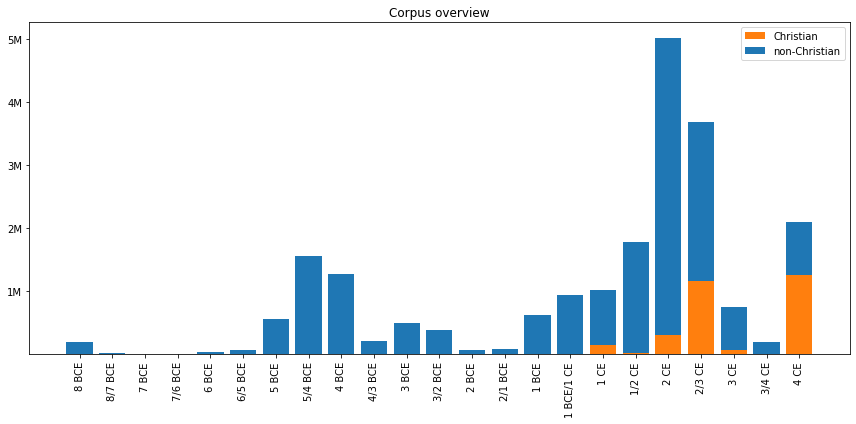

In [27]:
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
#subselections_df = subselections_df.iloc[::-1]
ax.bar(subselections_df["date_string"], subselections_df["wordcount_christian"], color="tab:orange", label="Christian")
ax.bar(subselections_df["date_string"], subselections_df["wordcount_pagan"], bottom=subselections_df["wordcount_christian"], label="non-Christian", color="tab:blue")


ax.set_yticks(range(1000000,6000000, 1000000))
ax.set_yticklabels(str(n) + "M" for n in range(1,6))
ax.set_xticklabels(subselections_df["date_string"], rotation=90)
ax.legend()
plt.title("Corpus overview")

In [28]:
sddk.write_file("SDAM_data/AGT/AGT_corpus_overview_20201119.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_corpus_overview_20201119.png"


In [29]:
subcorpora_dict = {# main subcorpora
    "Archaic (8-6 BCE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] <= -5.5)],
    "Classical (5-4 BCE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"].between(-5, -3))],
    "Non-Christian (1-4 CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Christian (1-4 CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}
   
subcorpora_dict_other = {
    # other relevant subcorpora (some overlaps)
    "Pagan (8th c. BCE - 4th c. CE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] < 4)],
    "Pagan (1st - 4th c. CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Septuagint" : AGT[AGT["author_id"]=="tlg0527"],
    "Philo of Alexandria" : AGT[AGT["author_id"]=="tlg0018"],
    "Titus Flavius Josephus" : AGT[AGT["author_id"]=="tlg0526"],
    "Paul of Tarsus" : AGT[AGT["author_id"]=="tlg0031paul"],
    "New Testament" : AGT[AGT["author_id"].str.startswith("tlg0031")],
    "Christian (1st - 4th c. CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}

In [30]:
subselections = []
for key in subcorpora_dict.keys():
    subselection = subcorpora_dict[key]
    subselection_dict = {}
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    sentences = subselection["lemmatized_sentences"].apply(lambda x: len(x)).sum()
    subselection_dict.update({"label" : key, "wordcount" : wordcount, "doccount" : doccount, "sentences" : sentences})
    subselections.append(subselection_dict)
subselections_df = pd.DataFrame(subselections)
subselections_df

,label,wordcount,doccount,sentences
0,Archaic (8-6 BCE),264919,11,20444
1,Classical (5-4 BCE),3411906,338,257156
2,Non-Christian (1-4 CE),8692448,411,723956
3,Christian (1-4 CE),2975644,131,291084


In [31]:
sddk.write_file("SDAM_data/AGT/AGT_20201119.json", AGT, conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_20201119.json"
